In [80]:
import csv
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
from scipy.optimize import brentq
import random as r

In [93]:
data = pd.read_csv("HYG_data/hygdata_v3.csv")
#from wikipedia
starclass = pd.read_csv("StarClass.csv")
#from http://www.isthe.com/chongo/tech/astro/HR-temp-mass-table-byhrclass.html
starclass_extended = pd.read_csv("StellarClass_Extended.csv")

In [25]:
starclass

,Class,Effective temperature (K),Vega-relative chromaticity,Chromaticity (D65),Main-sequence mass (solar masses),Main-sequence radius (solar radii),Main-sequence luminosity (bolometric),Hydrogen lines,Fraction of all main-sequence stars
0,O,">=30,000",blue,blue,>=16,>=6.6,">=30,000",Weak,0.00003
1,B,"10,000-30,000",blue white,deep blue white,2.1-16,1.8-6.6,"25-30,000",Medium,0.00130
2,A,"7,500-10,000",white,blue white,1.4-2.1,1.4-1.8,5-25,Strong,0.00600
3,F,"6,000-7,500",yellow white,white,1.04-1.4,1.15-1.4,1.5-5,Medium,0.03000
4,G,"5,200-6,000",yellow,yellowish white,0.8-1.04,0.96-1.15,0.6-1.5,Weak,0.07600
5,K,"3,700-5,200",light orange,pale yellow orange,0.45-0.8,0.7-0.96,0.08-0.6,Very weak,0.12100
6,M,"2,400-3,700",orange red,light orange red,0.08-0.45,<=0.7,<=0.08,Very weak,0.76450


In [90]:
starclass_extended
starclass_extended["Stellar Type"].astype("string")
avg = lambda nums : sum(nums)/len(nums)
#get the full details for some classification/part of a classification
starclass_extended[starclass_extended["Stellar Type"].str.contains("M8")]


,Stellar Type,Mass (Mstar/Msun),Luminosity (Lstar/Lsun),Radius (Rstar/Rsun),Temp (K),Color Index (B-V),Abs Mag (Mv),Bolo Corr (BC(Temp)),Bolo Mag (Mbol),Star Color (RGB 0-255)
544,M8Ia0,12.1,2.050000e+08,103000.000,2180,2.25,-9.1,-6.93,-16.03,255 157 000
545,M8Ia,10.1,2.700000e+07,37600.000,2180,2.25,-6.9,-6.93,-13.83,255 157 000
546,M8Ib,8.1,5.150000e+06,16400.000,2180,2.25,-5.1,-6.93,-12.03,255 157 000
547,M8II,6.1,7.440000e+05,6230.000,2180,2.25,-3.0,-6.93,-9.93,255 192 096
548,M8III,4.1,5.150000e+04,1640.000,2180,2.25,-0.1,-6.93,-7.03,255 167 097
549,M8IV,2.1,2.440000e+03,361.000,2167,2.26,3.3,-7.02,-3.72,255 206 151
550,M8V,0.1,3.530000e-03,0.434,2167,2.26,17.9,-7.02,10.88,255 198 109
551,M8VI,0.1,2.440000e-03,0.361,2167,2.26,18.3,-7.02,11.28,255 198 109


In [91]:
#M8 seems to have a fairly consistant temperature. We can call all M8* stars the average of the values
M8 = avg(starclass_extended[starclass_extended["Stellar Type"].str.contains("M8")]["Temp (K)"])

In [94]:
#query the data for specific things like this:
data[data.spect == "O9III"]

,id,hip,hd,hr,gl,bf,proper,ra,dec,dist,...,bayer,flam,con,comp,comp_primary,base,lum,var,var_min,var_max
26176,26176,26241.0,37043.0,1899.0,NaN,44Iot Ori,Hatsya,5.590551,-5.909901,714.2857,...,Iot,44.0,Ori,1,26176,NaN,3.528580e+04,NaN,NaN,NaN
43579,43579,43702.0,76341.0,NaN,NaN,NaN,NaN,8.900171,-42.485766,100000.0000,...,NaN,NaN,Vel,1,43579,NaN,1.191242e+07,NaN,NaN,NaN
65683,65683,65890.0,116852.0,NaN,NaN,NaN,NaN,13.506528,-78.855707,100000.0000,...,NaN,NaN,Cha,1,65683,NaN,3.499452e+06,NaN,NaN,NaN
84663,84663,84922.0,156359.0,NaN,NaN,NaN,NaN,17.355202,-62.918161,100000.0000,...,NaN,NaN,Ara,1,84663,NaN,1.180321e+06,NaN,NaN,NaN
99823,99823,100146.0,193443.0,NaN,NaN,NaN,NaN,20.314363,38.279583,100000.0000,...,NaN,NaN,Cyg,1,99823,NaN,1.086426e+07,NaN,NaN,NaN


In [44]:
ra = list(data["ra"])
id1=list(data["id"]) #the database primary key
hip=list(data["hip"]) #The star's ID in the Hipparcos catalog, if known
hd=list(data["hd"]) #The star's ID in the Henry Draper catalog, if known
hr=list(data["hr"]) #The star's ID in the Harvard Revised catalog
gl=list(data["gl"]) #The star's ID in the third edition of the Gliese Catalog of Nearby Stars
bf=list(data["bf"]) #The Bayer / Flamsteed designation
proper=list(data["proper"]) #common name for the star
ra=list(data["ra"]) #right ascension
dec=list(data["dec"]) #declination
dist=list(data["dist"]) #star's distance in parsecs
pmra=list(data["pmra"]) #star's proper motion in right ascension, in milliarcseconds per year
pmdec=list(data["pmdec"]) #star's proper motion in declination, in milliarcseconds per year
rv=list(data["rv"]) #The star's radial velocity in km/sec, where known
mag=list(data["mag"]) #The star's apparent visual magnitude
absmag=list(data["absmag"]) #star's absolute visual magnitude
spect=list(data["spect"]) #spectral type, if known
ci=list(data["ci"]) # star's color index (blue magnitude - visual magnitude), where known
x=list(data["x"]) # The Cartesian coordinates of the star
y=list(data["y"]) #
z=list(data["z"]) #
vx=list(data["vx"]) #The Cartesian velocity components of the star, parsecs per year
vy=list(data["vy"]) #
vz=list(data["vz"]) #
rarad=list(data["rarad"]) #right ascension in radians 
decrad=list(data["decrad"]) #declination in radians 
pmrarad=list(data["pmrarad"]) #proper motion right ascension, in radians 
pmdecrad=list(data["pmdecrad"]) #proper motion declination, in radians 
bayer=list(data["bayer"]) #The Bayer designation as a distinct value
flam=list(data["flam"]) #The Flamsteed number as a distinct value
con=list(data["con"]) #The standard constellation abbreviation
comp=list(data["comp"]) #Identifies a star in a multiple star system. comp = ID of companion star
comp_primary=list(data["comp_primary"]) #ID of primary star for this component
base=list(data["base"]) #catalog ID or name for this multi-star system
lum=list(data["lum"]) #Star's luminosity as a multiple of Solar luminosity
var=list(data["var"]) #Star's standard variable star designation, when known
var_min=list(data["var_min"]) #Star's approximate magnitude range, for variables
var_max=list(data["var_max"]) #


In [10]:
#create lists for these columns in the csv file
id1=[] #the database primary key
hip=[] #The star's ID in the Hipparcos catalog, if known
hd=[] #The star's ID in the Henry Draper catalog, if known
hr=[] #The star's ID in the Harvard Revised catalog
gl=[] #The star's ID in the third edition of the Gliese Catalog of Nearby Stars
bf=[] #The Bayer / Flamsteed designation
proper=[] #common name for the star
ra=[] #right ascension
dec=[] #declination
dist=[] #star's distance in parsecs
pmra=[] #star's proper motion in right ascension, in milliarcseconds per year
pmdec=[] #star's proper motion in declination, in milliarcseconds per year
rv=[] #The star's radial velocity in km/sec, where known
mag=[] #The star's apparent visual magnitude
absmag=[] #star's absolute visual magnitude
spect=[] #spectral type, if known
ci=[] # star's color index (blue magnitude - visual magnitude), where known
x=[] # The Cartesian coordinates of the star
y=[] #
z=[] #
vx=[] #The Cartesian velocity components of the star, parsecs per year
vy=[] #
vz=[] #
rarad=[] #right ascension in radians 
decrad=[] #declination in radians 
pmrarad=[] #proper motion right ascension, in radians 
pmdecrad=[] #proper motion declination, in radians 
bayer=[] #The Bayer designation as a distinct value
flam=[] #The Flamsteed number as a distinct value
con=[] #The standard constellation abbreviation
comp=[] #Identifies a star in a multiple star system. comp = ID of companion star
comp_primary=[] #ID of primary star for this component
base=[] #catalog ID or name for this multi-star system
lum=[] #Star's luminosity as a multiple of Solar luminosity
var=[] #Star's standard variable star designation, when known
var_min=[] #Star's approximate magnitude range, for variables
var_max=[] #


fields = [] #list of names of each column 

with open('HYG_data/hygdata_v3.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    fields = next(readCSV)
    for row in readCSV:
        id1.append(row[0])
        hip.append(row[1])
        hd.append(row[2])
        hr.append(row[3])
        gl.append(row[4])
        bf.append(row[5])
        proper.append(row[6])
        ra.append(row[7])
        dec.append(row[8])
        dist.append(row[9])
        pmra.append(row[10])
        pmdec.append(row[11])
        rv.append(row[12])
        mag.append(row[13])
        absmag.append(row[14])
        spect.append(row[15])
        ci.append(row[16])
        x.append(row[17])
        y.append(row[18])
        z.append(row[19])
        vx.append(row[20])
        vy.append(row[21])
        vz.append(row[22])
        rarad.append(row[23])
        decrad.append(row[24])
        pmrarad.append(row[25])
        pmdecrad.append(row[26])
        bayer.append(row[27])
        flam.append(row[28])
        con.append(row[29])
        comp.append(row[30])
        comp_primary.append(row[31])
        base.append(row[32])
        lum.append(row[33])
        var.append(row[34])
        var_min.append(row[35])
        var_max.append(row[36])

        

In [4]:
def convert(s):
    try:
        float(s) #check that each data point can be converted to float
        return float(s)
    except ValueError:
        return None 

stat ideas:


split stars into groups, different areas of the sky

compare star parameters in different areas of sky, look for statistically different sets



if ra <= __ and ra > __ and dec < ___ and dec __ > then:

group1.append(star)

else

group2.append(star)


look for correlations between:

1 total velocities 

2 absolute magnitude 

3 distance from earth

4 spectral type



generate HR diagrams

for each spectral type, get avg absolute mag w standard deviation, plot


to do:

convert spectral types to temp

get lists of floats for numerical analysis

In [57]:
uniques = set(spect)
print(uniques)

{nan, 'M4.5Ve', 'A6:III:+...', 'B5 + F2', 'G0Vw', 'G2Ib', 'B1Ia:', 'O6pe', 'B9.5III', 'B4/B5IV', 'M6IIIe-M8e', 'F7IIIw...', 'B9.5/A0III', 'F2+...', 'G6:III/IV+.', 'B7Ve...', 'B9IIIe...', 'K0/K1III:', 'M0V...', 'K3Ia0-a...', 'G5Ve(T)', 'B0.5:V:pe', 'Rpvar', 'F6/F7III/IV', 'F8Ibvar', 'O8', 'K1:III:', 'K0V...', 'G8IV:', 'C(R)', 'F3IV-V', 'G7', 'K5:...', 'F3/F5IV:', 'A8/A9IVw...', 'K0/K1IV/V', 'B8V', 'A:...', 'B0.5Iavar', 'G2wF6', 'A2 + A7', 'N', 'B3V SB', 'K5Iabvar', 'G1/G2IV/V', 'A7IVe', 'G8p...', 'A7/A8II/III', 'B4III', 'A6/A7IV/V', 'K0/K1IV', 'B9.5II/III', 'M2.5III:', 'dM1   J', 'sdF5', 'M5Ib-IIvar', 'B9p SiSrCr', 'F2/F3II', 'F2IV', 'A4/A5III/IV', 'sdG4', 'M1e', 'G6IV:', 'B0V:pe', 'F3Ib', 'B9.5IV/V +K2', 'M0/M1III:', 'B3/5V(p)', 'A0IIIn', 'M3Ia0', 'F6:+...', 'G8 V', 'A4/A7:m...', 'Ge', 'K0/K1+...', 'A7/A8V+...', 'K3.5IIb', 'A9', 'B8/B9IV/V', 'K8', 'A4/A5II/III', 'G8/K1(V)+(F)', 'K1IIpevar', 'F5:Ib-II', 'K4V:', 'F4IIIvar', 'B1.5V', 'F8/G0V', 'G2IV + K0IV', 'M4/M5', 'sdF7::', 'F8Ib/II', 

In [13]:
#use the set(someList) function to find all unique values in a list.
def unique(list1):
  
    # initialize a null list
    unique_list = []
  
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [14]:
allspects = []
spectypes = unique(spect)
spectypes.sort()
print(len(spectypes))
print(len(spect))
#print(spectypes)

4308
119614


In [8]:
temps = []
unknowns = 0
unknowntypes = []
for x in spect:
    if x == '':
        temps.append(0)
    elif x == 'O3V' or x == 'O3':
        temps.append(44900)
    elif x == 'O4V' or x == 'O4':
        temps.append(42900)
    elif x == 'O5V' or x == 'O5':
        temps.append(41400)
    elif x == 'O6V' or x == 'O6':
        temps.append(39500)
    elif x == 'O7V' or x == 'O7':
        temps.append(37100)
    elif x == 'O8V' or x == 'O8':
        temps.append(35100)
    elif x == 'O9V' or x == 'O9':
        temps.append(33300)
    elif x == 'A0V' or x == 'A0':
        temps.append(9700)
    elif x == 'A1V' or x == 'A1':
        temps.append(9300)
    elif x == 'A2V' or x == 'A2':
        temps.append(8800)
    elif x == 'A3V' or x == 'A3':
        temps.append(8600)
    elif x == 'A4V' or x == 'A4':
        temps.append(8250)
    elif x == 'A5V' or x == 'A5':
        temps.append(8100)
    elif x == 'A6V' or x == 'A6':
        temps.append(7910)
    elif x == 'A7V' or x == 'A7':
        temps.append(7760)
    elif x == 'A8V' or x == 'A8':
        temps.append(7590)
    elif x == 'A9V' or x == 'A9':
        temps.append(7400)
    elif x == 'B0V' or x == 'B0':
        temps.append(31400)
    elif x == 'B1V' or x == 'B1':
        temps.append(26000)
    elif x == 'B1.5V' or x == 'B1.5':    
        temps.append(24500)
    elif x == 'B2V' or x == 'B2':
        temps.append(20600)
    elif x == 'B2.5V' or x == 'B2.5':    
        temps.append(18500)
    elif x == 'B3V' or x == 'B3':
        temps.append(17000)
    elif x == 'B4V' or x == 'B4':
        temps.append(16400)
    elif x == 'B5V' or x == 'B5':
        temps.append(15700)
    elif x == 'B6V' or x == 'B6':
        temps.append(14500)
    elif x == 'B7V' or x == 'B7':
        temps.append(14000)
    elif x == 'B8V' or x == 'B8':
        temps.append(12300)
    elif x == 'B9V' or x == 'B9':
        temps.append(10700)
    elif x == 'B9.5V' or x == 'B9.5':
        temps.append(10400)
    elif x == 'G0v' or x == 'G0':
        temps.append(5930)
    elif x == 'G1V' or x == 'G1':
        temps.append(5860)
    elif x == 'G2V' or x == 'G2':
        temps.append(5770)
    elif x == 'G3V' or x == 'G3':
        temps.append(5720)
    elif x == 'G4V' or x == 'G4':
        temps.append(5680)
    elif x == 'G5V' or x == 'G5':
        temps.append(5660)
    elif x == 'G6V' or x == 'G6':
        temps.append(5600)
    elif x == 'G7V' or x == 'G7':
        temps.append(5550)
    elif x == 'G8V' or x == 'G8':
        temps.append(5480)
    elif x == 'G9V' or x == 'G9':
        temps.append(5380)
    elif x == 'F0V' or x == 'F0':
        temps.append(7220)
    elif x == 'F1V' or x == 'F1':
        temps.append(7020)
    elif x == 'F2V' or x == 'F2':
        temps.append(6820)
    elif x == 'F3V' or x == 'F3':
        temps.append(6750)
    elif x == 'F4V' or x == 'F4':
        temps.append(6670)
    elif x == 'F5V' or x == 'F5':
        temps.append(6550)
    elif x == 'F6V' or x == 'F6':
        temps.append(6350)
    elif x == 'F7V' or x == 'F7':
        temps.append(6280)
    elif x == 'F8V' or x == 'F8':
        temps.append(6180)
    elif x == 'F9V' or x == 'F9':
        temps.append(6050)
    elif x == 'K0V' or x == 'K0':
        temps.append(5270)
    elif x == 'K1V' or x == 'K1':
        temps.append(5170)
    elif x == 'K2V' or x == 'K2':
        temps.append(5100)
    elif x == 'K3V' or x == 'K3':
        temps.append(4830)
    elif x == 'K4V' or x == 'K4':
        temps.append(4600)
    elif x == 'K5V' or x == 'K5':
        temps.append(4440)
    elif x == 'K6V' or x == 'K6':
        temps.append(4300)
    elif x == 'K7V' or x == 'K7':
        temps.append(4100)
    elif x == 'K8V' or x == 'K8':
        temps.append(3990)
    elif x == 'K9V' or x == 'K9':
        temps.append(3930)
    elif x == 'M0V' or x == 'M0':
        temps.append(3850)
    elif x == 'M0.5V' or x == 'M0.5':
        temps.append(3770)
    elif x == 'M1V' or x == 'M1':
        temps.append(3660)
    elif x == 'M1.5V' or x == 'M1.5':
        temps.append(3620)
    elif x == 'M2V' or x == 'M2':
        temps.append(3560)
    elif x == 'M2.5V' or x == 'M2.5':
        temps.append(3470)
    elif x == 'M3V' or x == 'M3':
        temps.append(3430)
    elif x == 'M3.5V' or x == 'M3.5':
        temps.append(3270)
    elif x == 'M4V' or x == 'M4':
        temps.append(3210)
    elif x == 'M4.5V' or x == 'M4.5':
        temps.append(3110)
    elif x == 'M5V' or x == 'M5':
        temps.append(3060)
    elif x == 'M5.5V' or x == 'M5.5':
        temps.append(2930)
    elif x == 'M6V' or x == 'M6':
        temps.append(2810)
    elif x == 'M6.5V' or x == 'M6.5':
        temps.append(2740)
    elif x == 'M7V' or x == 'M7':
        temps.append(2680)
    elif x == 'M7.5V' or x == 'M7.5':
        temps.append(2630)
    elif x == 'M8V' or x == 'M8':
        temps.append(2570)
    elif x == 'M8.5V' or x == 'M8.5': 
        temps.append(2420)
    elif x == 'M9V' or x == 'M9': 
        temps.append(2380)
    elif x == 'M9.5V' or x == 'M9.5':
        temps.append(2350)
    else:
        temps.append(0)
        unknowns = unknowns +1
        unknowntypes.append(x)

In [9]:
print(unknowns)
unknowntypes.sort()
print(unknowntypes)

43683
['(G3w)F7', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A

In [10]:
unknowns/len(spect)

0.36519972578460713

In [11]:
lumvals = [convert(x) for x in lum]
absmagvals = [convert(x) for x in absmag]
vxvals = [convert(x) for x in vx]
vyvals = [convert(x) for x in vy]
vzvals = [convert(x) for x in vz]
vtot = []
for i in range(len(vxvals)):
    v2 = vxvals[i]*vxvals[i]+vyvals[i]*vyvals[i]+vzvals[i]*vzvals[i]
    v = v2**(.5)
    vtot.append(v)
#print(len(spect), len(lumvals), len(absmagvals))

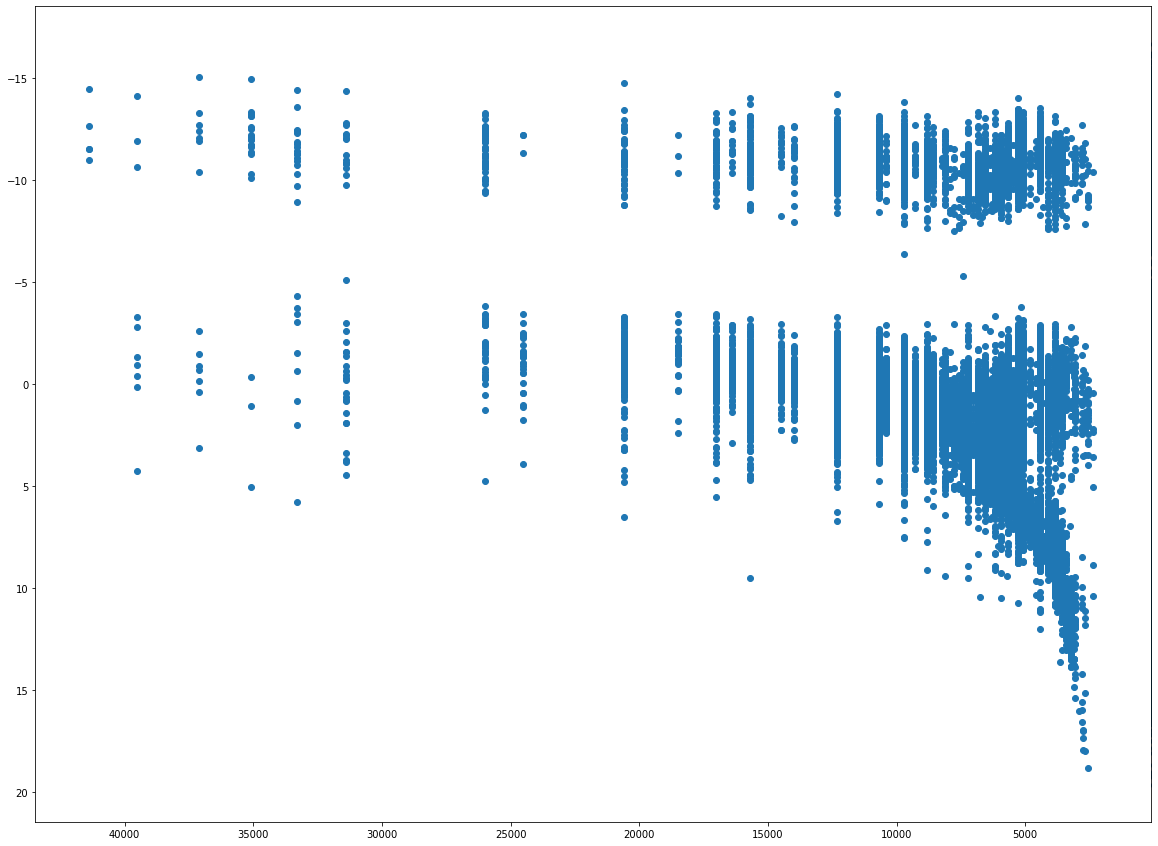

In [26]:
plt.figure(figsize=(20,15))
plt.xlim(100,max(temps)*1.05)

plt.scatter(temps,absmagvals)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

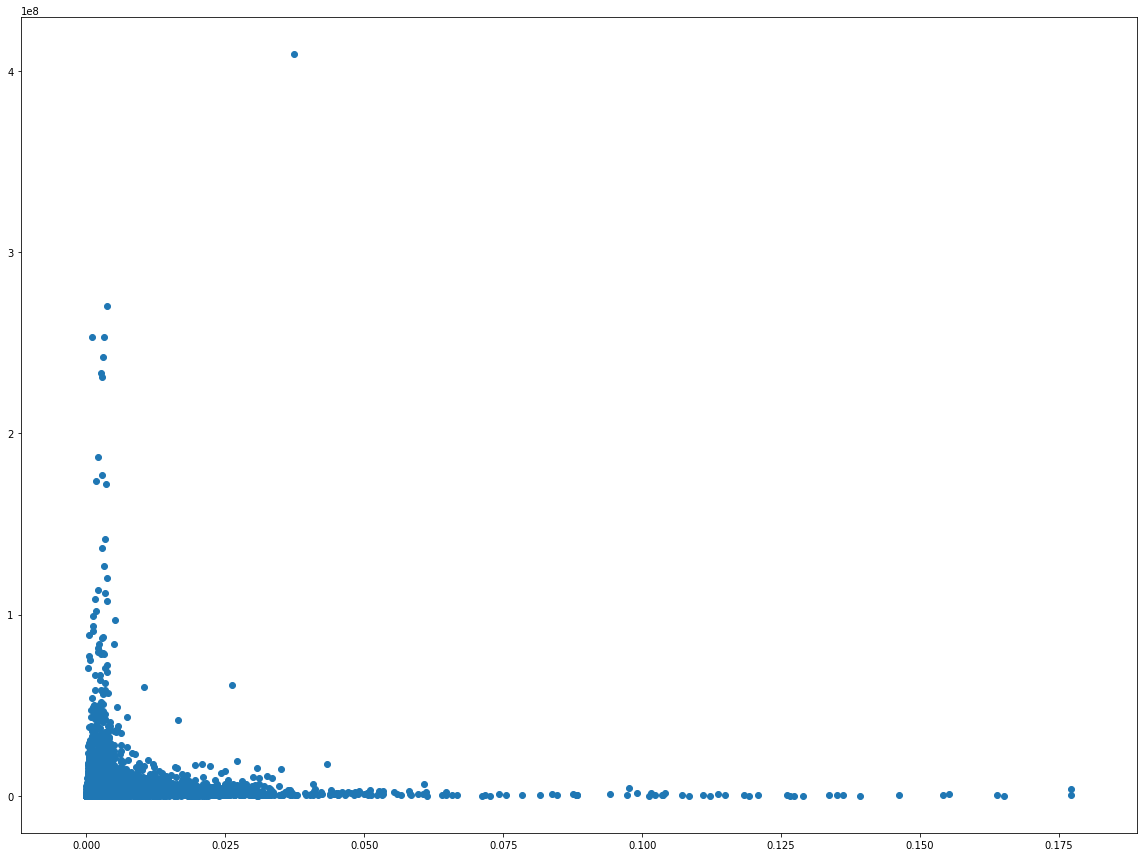

In [25]:
plt.figure(figsize=(20,15))


plt.scatter(vtot,lumvals)

<function matplotlib.pyplot.show(*args, **kw)>

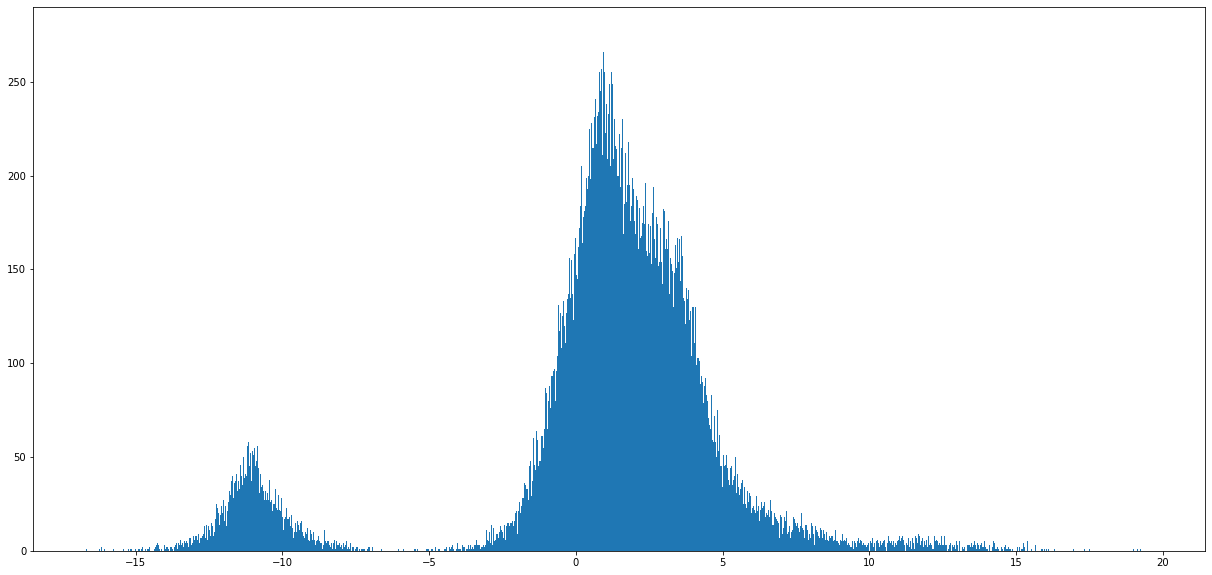

In [24]:
plt.figure(figsize=(21,10))
plt.hist(absmagvals, bins=np.arange(min(absmagvals),max(absmagvals),.01))
plt.show